# AutoML Generalized Framework

In [1]:
import numpy as np
import pandas as pd
from sklearn import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tpot import TPOTClassifier, TPOTRegressor
from datacleaner import autoclean
from collections import defaultdict
from yellowbrick.model_selection import FeatureImportances

In [2]:
class AutoMLEstimator(object):
    
    def __init__(self, **kwargs):
        
        self.task = kwargs['task']
        self.speed = kwargs['speed']
        self.test_size = kwargs['test_size']
        if self.task == 'classification':
            self.tpot_model = TPOTClassifier(generations=self.speed, population_size=self.speed*10, verbosity=2, n_jobs=-1)
        else:
            self.tpot_model = TPOTRegressor(generations=self.speed, population_size=self.speed*10, verbosity=2, n_jobs=-1)
        
    def preprocess_data(self, data, target_column):
        
        clean_data = autoclean(data)
        X = clean_data.drop(target_column, axis=1)
        y = clean_data[target_column]
        
        return X, y
    
    def split_data(self, X, y):
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self.test_size) 
    
    def fit_model(self):
        
        self.tpot_model.fit(self.X_train, self.y_train)
        
    def run_automl(self, data, target_column):
        
        self.X, self.y = self.preprocess_data(data, target_column)
        self.split_data(self.X, self.y)
        self.fit_model()
    
    def evaluate_model(self):
        
        metrics = defaultdict()
        pred = self.tpot_model.fitted_pipeline_.predict(self.X_test)
        
        if self.task == 'classification':
            
            metrics['accuracy'] = accuracy_score(pred, self.y_test)
            metrics['precision'] = precision_score(pred, self.y_test)
            metrics['recall'] = recall_score(pred, self.y_test)
            
        else:
            
            metrics['r2_score'] = r2_score(pred, self.y_test)
            metrics['mean_absolute_error'] = mean_absolute_error(pred, self.y_test)
            metrics['mean_squared_error'] = mean_squared_error(pred, self.y_test)
        
        return metrics

In [3]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [4]:
data.keys()

dict_keys(['data', 'filename', 'feature_names', 'target_names', 'DESCR', 'target'])

In [5]:
data['data'].shape

(569, 30)

In [6]:
data['feature_names'].shape

(30,)

In [7]:
data['target'].shape

(569,)

In [8]:
data['target_names']

array(['malignant', 'benign'], dtype='<U9')

In [9]:
df = pd.DataFrame(columns=data['feature_names'], data=data['data'])
df['target'] = data['target']

In [10]:
auto_ml_model = AutoMLEstimator(task='classification', speed=3, test_size=0.2)
auto_ml_model.run_automl(df, target_column='target')

Generation 1 - Current best internal CV score: 0.971377607899347
Generation 2 - Current best internal CV score: 0.9735509900727293
Generation 3 - Current best internal CV score: 0.9758220523437915
Generation 4 - Current best internal CV score: 0.9779954345171736


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: ExtraTreesClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=2, max_features=0.5, min_samples_leaf=20, min_samples_split=5, n_estimators=100, subsample=0.3), bootstrap=True, criterion=entropy, max_features=0.3, min_samples_leaf=10, min_samples_split=11, n_estimators=100)


In [11]:
list(auto_ml_model.tpot_model.evaluated_individuals_.values())[0]

{'crossover_count': 0,
 'generation': 'INVALID',
 'internal_cv_score': 0.9493003132133568,
 'mutation_count': 1,
 'operator_count': 2,
 'predecessor': ('GaussianNB(LinearSVC(input_matrix, LinearSVC__C=0.0001, LinearSVC__dual=True, LinearSVC__loss=hinge, LinearSVC__penalty=l2, LinearSVC__tol=0.0001))',)}

In [12]:
from sklearn.datasets import load_boston
data = load_boston()
df = pd.DataFrame(columns=data['feature_names'], data=data['data'])
df['target'] = data['target']
df.to_csv('boston_housing.csv')

In [13]:
auto_ml_model = AutoMLEstimator(task='regression', speed=3, test_size=0.3)
auto_ml_model.run_automl(df, target_column='target')

Generation 1 - Current best internal CV score: -11.059314890579422
Generation 2 - Current best internal CV score: -11.059314890579422
Generation 3 - Current best internal CV score: -11.059314890579422
Generation 4 - Current best internal CV score: -10.467802951255536
Generation 5 - Current best internal CV score: -10.467802951255536

Best pipeline: XGBRegressor(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.8, min_samples_leaf=2, min_samples_split=6, n_estimators=100), learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100, nthread=1, objective=reg:squarederror, subsample=0.25)


In [14]:
auto_ml_model.evaluate_model()

defaultdict(None,
            {'mean_absolute_error': 2.455483083348525,
             'mean_squared_error': 12.252844950523748,
             'r2_score': 0.8368706920462654})

In [15]:
type(auto_ml_model.tpot_model.fitted_pipeline_[-1]).__name__

'XGBRegressor'

In [18]:
auto_ml_model.tpot_model.fitted_pipeline_.steps[-1][1].feature_importances_

array([0.6365785 , 0.03212562, 0.04282403, 0.01748819, 0.00345527,
       0.02089561, 0.03441943, 0.01834604, 0.05724856, 0.02714156,
       0.02433833, 0.02219093, 0.03140829, 0.03153977], dtype=float32)

In [22]:
best_model = auto_ml_model.tpot_model.fitted_pipeline_.steps[-1][1]

//anaconda/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
//anaconda/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


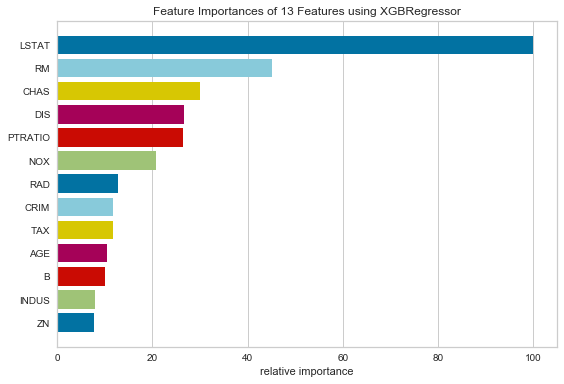

matplotlib.axes._subplots.AxesSubplot

In [29]:
plt.figure()
viz = FeatureImportances(best_model, is_fitted=False)
viz.fit(df.drop('target', axis=1), df['target'])
viz.show()